<a href="https://colab.research.google.com/github/pythonpdnp/DL/blob/main/ANN_multiOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

## iris 데이터

### 데이터 입력 및 전처리

In [ ]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

In [ ]:
sns.pairplot(iris, hue='species')
plt.show()

In [ ]:
data = torch.tensor(iris.iloc[:, :-1].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2    # 나머지는 전부 0(setosa)

labels

### 모델 셋팅

In [ ]:
ANNiris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)

### 모델 train

In [ ]:
numEpochs = 1000

losses = torch.zeros(numEpochs)
onGoingAcc = []

for epoch in range(numEpochs):
  yhat = ANNiris(data)    # Forward pass
  loss = lossFunc(yhat, labels)    # loss 계산
  losses[epoch] = loss

  # Back Propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # accuracy 계산
  matches = (torch.argmax(yhat, axis=1) == labels).float()
  accuracy = matches.mean() * 100
  onGoingAcc.append(accuracy)


In [ ]:
# final forward pass

pred_prod = ANNiris(data)
pred = torch.argmax(pred_prod, axis=1)
totalAcc = torch.mean((pred == labels).float())

### Visualize the Result

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(losses.detach())
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(onGoingAcc)
ax[0].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy')

fig.suptitle(f'Final accuracy {totalAcc:.2f}%', fontsize=16)
fig.tight_layout()

plt.show()


In [ ]:
# softmax 함수 사용 예제
sm = nn.Softmax(dim=1)
torch.sum(sm(yhat), axis=1)

In [ ]:
plt.plot(sm(yhat).detach().numpy(), 's-', markerfacecolor='w')
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.show()

## custom data

### 데이터 생성

In [53]:
def dataGen(nPerClust=1000, blur=1):

  A = [ 1,  1 ]
  B = [ 5,  1 ]
  C = [ 3, -2 ]

  # 데이터 생성
  a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
  b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]
  c = [ C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur ]

  data_np = np.hstack((a,b,c)).T
  data = torch.tensor(data_np).float()

  # 레이블 생성
  label0 = np.zeros((nPerClust,1))
  label1 = np.ones((nPerClust,1))
  label2 = np.ones((nPerClust,1))*2

  labels_np = np.vstack((label0,label1,label2))
  labels = torch.squeeze(torch.tensor(labels_np).long())      # 1차원 pytorch 벡터로 변환



  return data, labels

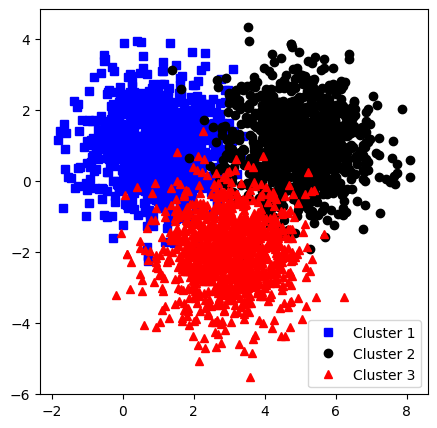

In [54]:
data,labels = dataGen()

cluster1 = data[np.where(labels==0)]
cluster2 = data[np.where(labels==1)]
cluster3 = data[np.where(labels==2)]

fig = plt.figure(figsize=(5,5))
plt.plot(cluster1[:,0], cluster1[:,1], 'bs', label='Cluster 1')
plt.plot(cluster2[:,0], cluster2[:,1], 'ko', label='Cluster 2')
plt.plot(cluster3[:,0], cluster3[:,1], 'r^', label='Cluster 3')
plt.legend()

plt.show()

### 신경망 구성 및 모델학습

In [69]:
def customANN(num_epochs=10000):

  # 신경망 구성
  ANNclf = nn.Sequential(
      nn.Linear(2,4),
      nn.ReLU(),
      nn.Linear(4,3),
      nn.Softmax(dim=1)    # 열방향으로 소프트맥스 함수 적용, 즉 각 행의 합은 1
  )

  lossfn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNclf.parameters(), lr=0.01)

  # 모델 학습
  losses = torch.zeros(num_epochs)
  onGoingAcc =[]

  for epoch in range(num_epochs):
    yhat = ANNclf(data)
    loss = lossfn(yhat,labels)
    losses[epoch] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # accuracy 계산
    matches = torch.argmax(yhat, axis=1) == labels
    accuracy = matches.float().mean() * 100
    onGoingAcc.append(accuracy)


  return ANNclf, losses, onGoingAcc

In [70]:
data, labels = dataGen()
ANNclf, losses, onGoingAcc = customANN()

pred = ANNclf(data)
predLabels = torch.argmax(pred, axis=1)
totalAcc = torch.mean((predLabels == labels).float())

### 학습내용 시각화

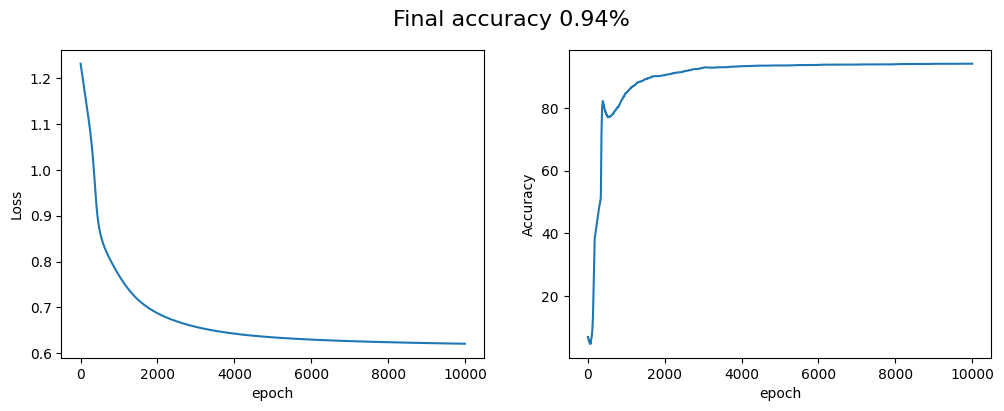

In [71]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(losses.detach())
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(onGoingAcc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy')

plt.suptitle(f'Final accuracy {totalAcc:.2f}%', fontsize=16)
plt.show()